# Implementation of the Fast KNN algorithm: Hierarchical Navigable Small Worlds

Import the necessary libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from tqdm.notebook import tqdm
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms as T
from bisect import insort
from heapq import heapify, heappop, heappush
import time

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In this project we use the MNIST dataset of handwritten digits.

In [3]:
mean = (0.1307,)
std = (0.3081,)

transform = T.Compose([T.ToTensor(), T.Normalize(mean, std)])

train_dataset = torchvision.datasets.MNIST('data/MNIST', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.MNIST('data/MNIST', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=False)

In [4]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Drawing some pictures from the training sample.

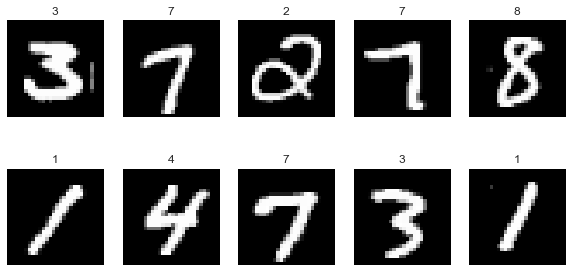

In [5]:
def image_restore(image, mean, std):
    return image * torch.tensor(std).view(1, 1, 1) + torch.tensor(mean).view(1, 1, 1)

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()
for i in range(10):
    image = image_restore(images[i], mean, std)
    axes[i].imshow(np.transpose(image, (1, 2, 0)), cmap='gray')
    axes[i].set_title(labels[i].item())
    axes[i].grid('off')
    axes[i].axis('off')
plt.show()

Visualizing data using TSNE.

In [6]:
num_samples_tsne = 5000
num_samples_dataset = len(train_dataset)
indices_tsne = np.random.choice(range(num_samples_dataset), size=num_samples_tsne, replace=False)
dataset_tsne = train_dataset.data[indices_tsne]
y_tsne = np.array(train_dataset.targets)[indices_tsne]

tsne = TSNE(perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(dataset_tsne.reshape(dataset_tsne.shape[0], -1))

Counting the number of instances of each class.

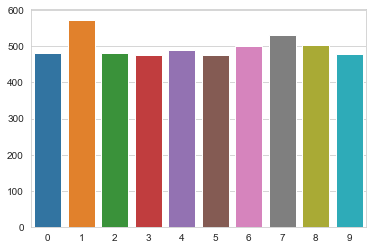

In [7]:
y_tsne_cnt = np.zeros(10)
for i in range(10):
     y_tsne_cnt[i] = np.sum(y_tsne == i)
        
sns.barplot(x=np.arange(10), y=y_tsne_cnt);

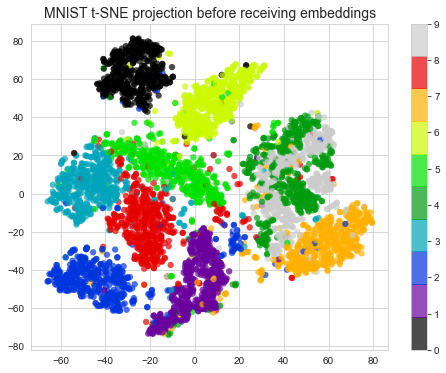

In [8]:
plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_tsne, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))

plt.colorbar()
plt.title('MNIST t-SNE projection before receiving embeddings', fontsize=14);

Some classes are poorly separable. Let's try to fix this by getting embeddings using a convolutional neural network.

In [9]:
class ConvNN(nn.Module):
    def __init__(self, img_chs=1):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=img_chs, out_channels=6, kernel_size=5, padding='same'), # 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(2), # 14 x 14
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5, padding='same'), # 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(2), # 7 x 7
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=5) # 3 x 3
        )
        
        self.head = nn.Sequential(
            nn.Linear(in_features=126, out_features=54), # 126
            nn.ReLU(),
            nn.Linear(in_features=54, out_features=10)
        )
    
    def forward(self, x):
        out = self.encoder(x)
        out = nn.Flatten()(out)
        out = self.head(out)
        return out
    
    def get_embedding(self, x):
        out = self.encoder(x)
        return nn.Flatten()(out)

In [10]:
def train(model, optimizer, criterion, n_epochs, batch_size):
    train_loss_log, train_acc_log = [], []
    val_loss_log, val_acc_log = [], []
    for epoch in tqdm(range(n_epochs)):
        train_loss, train_acc = train_epoch(model, optimizer, criterion)
        val_loss, val_acc = test(model, criterion)
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        steps = len(train_dataset.targets) / batch_size
        val_loss_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))
    plot_losses(train_loss_log, val_loss_log, train_acc_log, val_acc_log)  
    return {
        'train_logloss': np.mean(train_loss), 'train_accuracy': np.mean(train_acc),
        'val_logloss': val_loss_log[-1], 'val_accuracy': val_acc_log[-1]
    }

In [11]:
def train_epoch(model, optimizer, criterion):
    loss_log, acc_log = [], []
    model.train()
    for x_batch, y_batch in train_loader:
        x_batch.to(device)
        y_batch.to(device)
        optimizer.zero_grad()
        logits = model(x_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        pred = torch.max(logits, 1)[1].data.numpy()
        acc = np.mean(pred == y_batch.data.numpy())
        acc_log.append(acc)
        loss_log.append(loss.item())
    return loss_log, acc_log 

In [12]:
def test(model, criterion):
    loss_log, acc_log = [], []
    model.eval()
    for x_batch, y_batch in val_loader:
        x_batch.to(device)
        y_batch.to(device)
        with torch.no_grad():
            logits = model(x_batch)
            loss = criterion(logits, y_batch)
        pred = torch.max(logits, 1)[1].data.numpy()
        acc = np.mean(pred == y_batch.data.numpy())
        acc_log.append(acc)
        loss_log.append(loss.item())
    return loss_log, acc_log

In [13]:
def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    axs[0].plot(train_losses, label='train', zorder=1)
    points = np.array(test_losses)
    axs[0].scatter(points[:, 0], points[:, 1], marker='o', s=60, c='red', label='val', zorder=2)
    axs[0].set_ylabel('loss', fontsize=15)
    axs[0].legend(fontsize=15)
    axs[1].plot(train_accuracies, label='train', zorder=1)
    points = np.array(test_accuracies)
    axs[1].scatter(points[:, 0], points[:, 1], marker='o', s=60, c='red', label='val', zorder=2)
    axs[1].set_ylabel('accuracy', fontsize=15)
    axs[1].legend(fontsize=15)
    for ax in axs:
        ax.set_xlabel('step', fontsize=15)
    plt.show()

  0%|          | 0/2 [00:00<?, ?it/s]

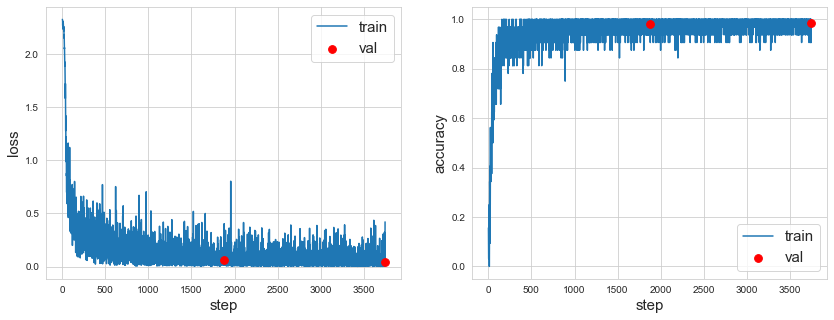

In [14]:
num_epochs = 2
model = ConvNN(img_chs=1).to(device)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())
history = train(model, opt, criterion, n_epochs=num_epochs, batch_size=32)

In [15]:
print('train_logloss:', f"{history['train_logloss']:.3f}")
print('val_logloss:', f"{history['val_logloss'][-1]:.3f}")

print('train_accuracy:', f"{history['train_accuracy']:.3f}")
print('val_accuracy:', f"{history['val_accuracy'][-1]:.3f}")

train_logloss: 0.069
val_logloss: 0.042
train_accuracy: 0.979
val_accuracy: 0.987


Embedding extraction for train data.

In [16]:
dataset_emb_tsne, y_train = [], []
for x_batch, y_batch in train_loader:
    x_batch.to(device)
    y_batch.to(device)
    with torch.no_grad():
        emb = model.get_embedding(x_batch).numpy()
        dataset_emb_tsne.extend(emb)
    y_train.extend(y_batch.numpy())
y_train = np.array(y_train)
dataset_emb_tsne = np.array(dataset_emb_tsne)
X_emb = dataset_emb_tsne[indices_tsne]
y_tsne = y_train[indices_tsne]

In [17]:
tsne = TSNE(perplexity=30, random_state=42)
X_emb_tsne = tsne.fit_transform(X_emb.reshape(X_emb.shape[0], -1))

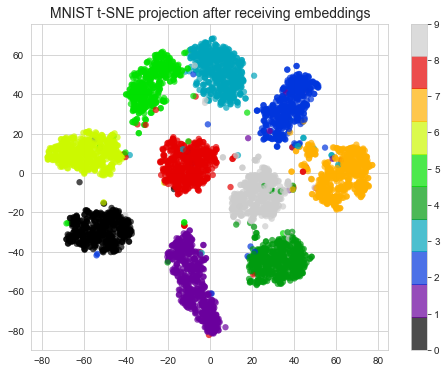

In [18]:
plt.figure(figsize=(8,6))
plt.scatter(X_emb_tsne[:, 0], X_emb_tsne[:, 1], c=y_tsne, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))

plt.colorbar()
plt.title('MNIST t-SNE projection after receiving embeddings', fontsize=14);

In [19]:
X_train = dataset_emb_tsne
X_train.shape, y_train.shape

((60000, 126), (60000,))

Embedding extraction for test data.

In [20]:
X_test, y_test = [], []
for x_batch, y_batch in val_loader:
    x_batch.to(device)
    y_batch.to(device)
    with torch.no_grad():
        emb = model.get_embedding(x_batch).numpy()
        X_test.extend(emb)
    y_test.extend(y_batch.numpy())
X_test = np.array(X_test)
y_test = np.array(y_test)

In [21]:
X_test.shape, y_test.shape

((10000, 126), (10000,))

We select only part of the data to build the model faster.

In [22]:
num_samples_test = 10000
num_samples_train = 2000
idx_train = np.random.choice(range(X_train.shape[0]), size=num_samples_test, replace=False)
idx_test = np.random.choice(range(X_test.shape[0]), size=num_samples_train, replace=False)
X_train = X_train[idx_train]
y_train = y_train[idx_train]
X_test = X_test[idx_test]
y_test = y_test[idx_test]

Finding the nearest neighbors to compare the quality of the algorithm's work. To assess the quality of the model, k equal to 20 neighbors is used.

In [23]:
k = 20
nbrs = NearestNeighbors(n_neighbors=k).fit(X_train)
_, indices = nbrs.kneighbors(X_test)

Hierarchical Navigable Small World is a graph-based algorithm that performs approximate nearest neighbor searches. The main idea of HNSW is to construct such a graph where a path between any pair of nodes could be traversed in a small number of steps. Its structure represents a multi-layered graph with fewer connections on the top layers and more dense regions on the bottom layers.

References:

- [Efficient and robust approximate nearest neighbor search using Hierarchical Navigable Small World graphs.](http://arxiv.org/pdf/1603.09320)

In [24]:
class HNSW():
    def __init__(self, num_layers, num_samples):
        self.graphs = [[None]*num_samples for _ in range(num_layers)]
        self.data = None   
        
    def graphs_construction(self, data, M, M_max, ef_c, scale):
        self.data = data
        for layer in self.graphs:
            layer[0] = np.array([], dtype=np.int32)
        for query in tqdm(range(1, self.data.shape[0])):
            self.insert(query, M, M_max, ef_c, scale)
    
    def insert(self, query, M, M_max, ef_c, scale):
        """
        Inserts element qquery into HNSW structure.

        Parameters
        ----------
        query : new element
        M :  number of established connections
        M_max : maximum number of connections for each element per layer
        ef_c : size of the dynamic candidate list
        scale : normalization factor for level generation
        """
        M_max_0 = 2 * M_max
        enter_p = 0
        L = len(self.graphs) - 1
        l = self.get_layer(scale, L)
        
        for layer_num in range(L, l, -1):
            layer = self.graphs[layer_num]
            nearest_els = self.search_layer(query, enter_p, ef=1, layer=layer)
            enter_p = nearest_els[0]
            
        for layer_num in range(l, 0, -1):
            layer = self.graphs[layer_num]
            nearest_els = self.search_layer(query, enter_p, ef_c, layer)
            neighbors = self.select_neighbors_simple(query, nearest_els, M) 
            layer[query] = neighbors
            for neighbor in neighbors:
                layer[neighbor] = np.append(layer[neighbor], query)
                if len(layer[neighbor]) > M_max:
                    self.shrink_connections(neighbor, M_max, layer)
            enter_p = self.get_nearest_element(nearest_els, query)
            
        layer = self.graphs[0]
        nearest_els = self.search_layer(query, enter_p, ef_c, layer)
        neighbors = self.select_neighbors_simple(query, nearest_els, M)
        layer[query] = neighbors
        for neighbor in neighbors:
            layer[neighbor] = np.append(layer[neighbor], query)
            if len(layer[neighbor]) > M_max_0:
                self.shrink_connections(neighbor, M_max_0, layer)
        
    def get_layer(self, scale, L):
        return min(L, int(np.random.exponential(scale=scale, size=1)))
    
    def search_layer(self, query, enter_p, ef, layer):
        """
        Searches for nearest neighbors to query.

        Parameters
        ----------
        query : new element
        enter_p : entrance point
        ef : size of the dynamic candidate list
        layer : list of X_train's lenght

        Returns
        -------
        nearest_ns: ef closest neighbors to query
        """
        dist_idx = [self.metrics(enter_p, query), enter_p]
        visited = set([enter_p])
        candidates = [dist_idx]
        heapify(candidates)
        nearest_ns = [dist_idx]
        
        while len(candidates) > 0:
            n_el = heappop(candidates)
            f_el = nearest_ns[-1]
            if n_el[0] > f_el[0]: 
                break
            for el in layer[n_el[1]]:
                if el not in visited:
                    visited.add(el)
                    f_el = nearest_ns[-1]
                    dist = self.metrics(el, query)
                    if dist < f_el[0] or len(nearest_ns) < ef:
                        heappush(candidates, [dist, el])
                        insort(nearest_ns, [dist, el])
                        if len(nearest_ns) > ef:
                            nearest_ns.pop()                   
        return np.array(nearest_ns, dtype=np.int32)[:,1]
        
    def get_nearest_element(self, candidates, query):                         
        distances = self.metrics(candidates, query)
        return candidates[np.argmin(distances)]
    
    def get_furthest_element(self, candidates, query):
        distances = self.metrics(candidates, query)
        return candidates[np.argmax(distances)]
    
    def metrics(self, idx_el, query):
        if type(query) == np.ndarray:
            query_array = query
        else:
            query_array = self.data[query]
        if type(idx_el) == np.ndarray:
            return np.sum(np.power((self.data[idx_el] - query_array), 2), axis=1)
        else:
            return np.sum(np.power((self.data[idx_el] - query_array), 2))
    
    def select_neighbors_simple(self, query, closest_n, M):
        if len(closest_n) <= M:
            return closest_n
        distances = self.metrics(closest_n, query)
        return closest_n[np.argpartition(distances, M)[:M]]   
    
    def shrink_connections(self, element, M, layer):
        distances = self.metrics(layer[element], element)
        layer[element] =  layer[element][np.argpartition(distances, M)[:M]]
                
    def ann_search(self, query_array, k, ef):
        """
        Searches for nearest neighbors to queries from query_array.

        Parameters
        ----------
        query_array : ndarray of shape (num_samples, num_features)
        k : number of nearest neighbors
        ef : size of the dynamic candidate list

        Returns
        -------
        nearest_neighbors: ndarray of shape (num_samples, k)
        """
        nearest_neighbors = []
        L = len(self.graphs) - 1
        for idx, query in enumerate(query_array):
            enter_p = 0
            for layer_num in range(L, 0, -1):
                layer = self.graphs[layer_num]
                nearest_els = self.search_layer(query, enter_p, ef=1, layer=layer)
                enter_p = nearest_els[0]
            layer = self.graphs[0]
            nearest_els =  self.search_layer(query, enter_p, ef=ef, layer=layer)
            neighbors = self.select_neighbors_simple(query, nearest_els, k)
            nearest_neighbors.append(neighbors)
        return np.array(nearest_neighbors)

In [25]:
num_samples = X_train.shape[0]
num_layers = 2
ef_c = 20
M_array = np.array(np.linspace(2, 20, 5), dtype=int)
recall_array = []
time_array = []

for M in M_array:
    M_max = M
    scale = 1 / np.log(M)
    model = HNSW(num_layers, num_samples)
    model.graphs_construction(X_train, M, M_max, ef_c, scale)
    
    ef_search = 15
    start_time = time.time()
    ann = model.ann_search(X_test, k, ef=ef_search)
    end_time = time.time()
    time_array.append(end_time - start_time)
    recall = 0
    for i in range(ann.shape[0]):
        recall += len(np.intersect1d(indices[i], ann[i]))
    recall /= ann.size
    recall_array.append(recall)

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

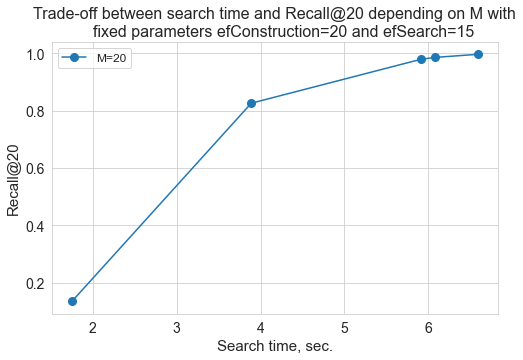

In [26]:
plt.figure(figsize=(8, 5))
plt.plot(time_array, recall_array,marker='o', markersize=8,  label=f'M={M}')
plt.xlabel('Search time, sec.', fontsize=15)
plt.ylabel(f'Recall@{k}', fontsize=15)
plt.title(
    f"""Trade-off between search time and Recall@{k} depending on M with
    fixed parameters efConstruction={ef_c} and efSearch={ef_search}""",
    fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.show()